Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Accuracy: 0.9256756756756757
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       369
           1       0.95      0.90      0.92       371

    accuracy                           0.93       740
   macro avg       0.93      0.93      0.93       740
weighted avg       0.93      0.93      0.93       740



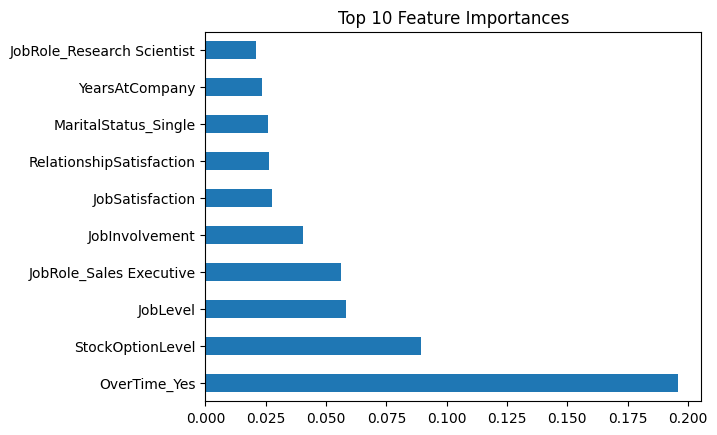

In [2]:

import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE  
from xgboost import XGBClassifier  


df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
drop_columns = ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours']
df = df.drop(drop_columns, axis=1)
low_variance_cols = [col for col in df.columns if df[col].nunique() == 1]
df = df.drop(columns=low_variance_cols)

categorical_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

numeric_cols = ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 
                'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 
                'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 
                'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 
                'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 
                'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

X = df.drop(columns=['Attrition'])
y = LabelEncoder().fit_transform(df['Attrition'])  # Encode target as binary (0/1)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}
grid_search = GridSearchCV(xgb_model, param_grid=xgb_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


import matplotlib.pyplot as plt

feature_importances = pd.Series(best_model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.show()
